# Compare hexbin maps of MERRA-2 SMB anomaly (%) and ICESat-2 deltaH over 1 year. Consider cycles 1 and 5 
# To do:
1. Right now I only consider annual mean SMB, not the exact mean of the period between the two dates!
2. Use a better ice shelf mask
3. Make the code fast
4. Use more data

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import geopandas as gpd
import os
import random

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr
from scipy import interpolate
from palettable.colorbrewer.diverging import *
from palettable.cmocean.sequential import *

# Miscalaneous

In [2]:
# Get Antarctic coastlines data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map settings
nbins=75 # Default is 75
extent = (-2800e3, 2800e3, -2800e3, 2800e3)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Functions

In [3]:
def time_str_datetime(time_str):
    t = pd.Series(pd.date_range(time_str, periods=1, freq='D'))
    t = datetime.strptime(np.datetime_as_string(t, unit='D')[0], '%Y-%m-%d')
    return t

def convert_lat_lon_to_epsg3031(lon, lat):
    
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo
    
    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)

    # Initialize arrays
    x = np.zeros(len(lon)); x[:] = np.nan
    y = np.zeros(len(lat)); y[:] = np.nan

    # Perform transformation
    for j in range(0, len(x)):
        coords = transform.TransformPoint(lat[j], lon[j])
        x[j], y[j] = coords[0:2]
    
    return x, y

def get_M2_smb(t0, tf):
    '''
    Calculate accumulated MERRA-2 SMB between two times in units of kg/m^2
    '''
    ds = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
    ais_mask = xr.open_dataset("/pl/active/nasa_smb/Data/AIS_basins_Zwally_MERRA2grid.nc")
    ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
    ind0 = ds.indexes["time"].get_loc(t0,  method="nearest")
    indf = ds.indexes["time"].get_loc(tf,  method="nearest")
    smb = ds["__xarray_dataarray_variable__"][ind0:indf,:,:].sum(dim='time')
    smb = smb * ais_mask
    
    lon = smb['lon'].values
    lat = smb['lat'].values
    lon, lat = np.meshgrid(lon, lat)
    x, y = convert_lat_lon_to_epsg3031(lon.flatten(), lat.flatten())
    smb = smb.values.flatten()
    
    return smb, x, y

def daily_climatology(ds):
    day = ds['time.dayofyear']
    day.name = 'day'
    return ds.groupby(day).mean('time')

def get_M2_smb_climatology(t0, tf):
    ais_mask = xr.open_dataset("/pl/active/nasa_smb/Data/AIS_basins_Zwally_MERRA2grid.nc")
    ais_mask = ais_mask['Zwallybasins'] / ais_mask['Zwallybasins']
    ds = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
    smb_daily_climatology = ds.apply(daily_climatology)
    mean_smb = smb_daily_climatology["__xarray_dataarray_variable__"].sum(dim='day')
    mean_smb = mean_smb * ais_mask
    mean_smb = mean_smb.values.flatten()
    return mean_smb

def plot_hexbin(x, y, C, nbins, extent, colormap, label, vmin="", vmax=""):
    
    # Generate figure 
    fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                            figsize=(12, 12))

    # Plot hexbin
    if type(vmin) == float and type(vmax) == float:
        hb = axs.hexbin(x, y, C=C, reduce_C_function=np.median, gridsize=nbins, extent=extent, cmap=colormap, alpha=1, vmin=vmin, vmax=vmax)
    else:
        hb = axs.hexbin(x, y, C=C, reduce_C_function=np.median, gridsize=nbins, extent=extent, cmap=colormap, alpha=1)
    
    cbar = plt.colorbar(hb, ax=axs, orientation='horizontal')
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label(label, size=32)

    # Plot coastlines
    axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
    axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                          facecolor='none', edgecolor='black')
    
    return hb

# Plot two tracks

In [4]:
# Define files
src_paths = glob.glob("../data/pt*") # Every path
random.shuffle(src_paths)
print(len(src_paths))

# Initialize arrays
x = np.array([])
y = np.array([])
h0 = np.array([])
hf = np.array([])
t0 = np.array([])
tf = np.array([])

# for j in range(0, len(src_paths)):
for j in range(0, 2000): # Use 1000
    print(j)
    ds = xr.open_dataset(src_paths[j])
    x = np.append(x, ds['x'].values)
    y = np.append(y, ds['y'].values)
    h0 = np.append(h0, ds['Height'][:,0].values)
    t0 = np.append(t0, np.nanmean(ds['Time'][:,0].values))
    hf = np.append(hf, ds['Height'][:,4].values)
    tf = np.append(tf, np.nanmean(ds['Time'][:,4].values))
    
h0[h0 < 1000] = np.nan # Filter everything below 1000m
hf[hf < 1000] = np.nan # Filter everything below 1000m
dh = 100 * (hf - h0) # Units cm

12453
0
1
2
3
4


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


5
6
7
8
9
10
11
12
13
14
15
16
17


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
28

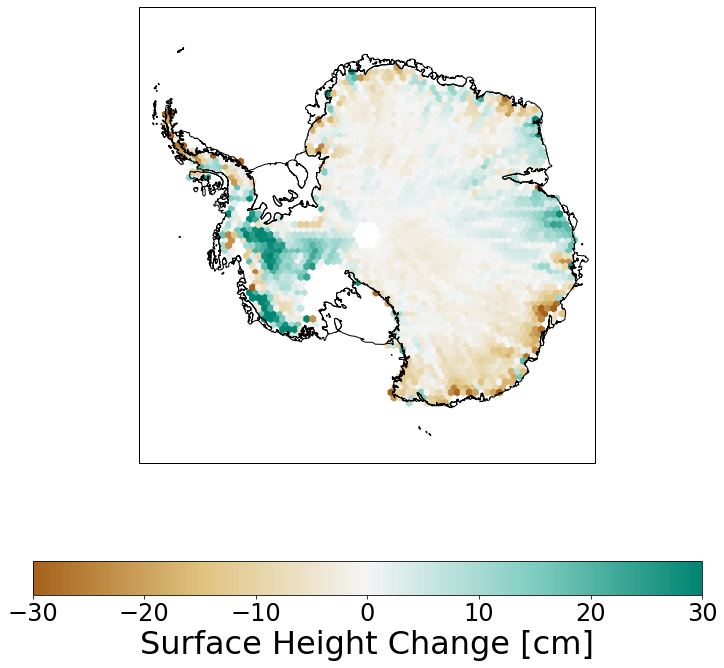

In [5]:
# QC data
dh[np.abs(dh) > 50] = np.nan

# Plot map
label = "Surface Height Change [cm]"
dh_hb = plot_hexbin(x, y, dh, nbins, extent, BrBG_5.mpl_colormap, label, -30.0, 30.0)

(-50, 50)

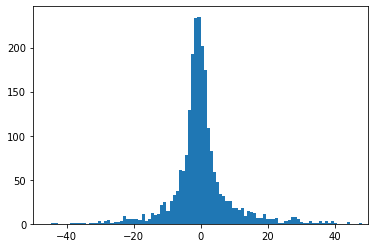

In [6]:
array = dh_hb.get_array()
plt.hist(array, bins=100)
plt.xlim([-50, 50])

# Get min and max time

In [7]:
base_time = pd.Series(pd.date_range('2018-01-01', periods=1, freq='D'))

t0 = pd.Timedelta(np.nanmean(t0), unit='s') + base_time
t0 = datetime.strptime(np.datetime_as_string(t0, unit='D')[0], '%Y-%m-%d')
t0 = str(t0)[0:10]
print(t0)

tf = pd.Timedelta(np.nanmean(tf), unit='s') + base_time
tf = datetime.strptime(np.datetime_as_string(tf, unit='D')[0], '%Y-%m-%d')
tf = str(tf)[0:10]
print(tf)

2019-05-13
2020-05-11


# Get M2 SMB anomaly

In [8]:
# Define time
t0 = time_str_datetime(t0)
tf = time_str_datetime(tf)
print(t0)
print(tf)

smb, x_M2, y_M2 = get_M2_smb(t0, tf)
mean_smb = get_M2_smb_climatology(t0, tf)
anomaly = (smb - mean_smb) / mean_smb * 100

2019-05-13 00:00:00
2020-05-11 00:00:00


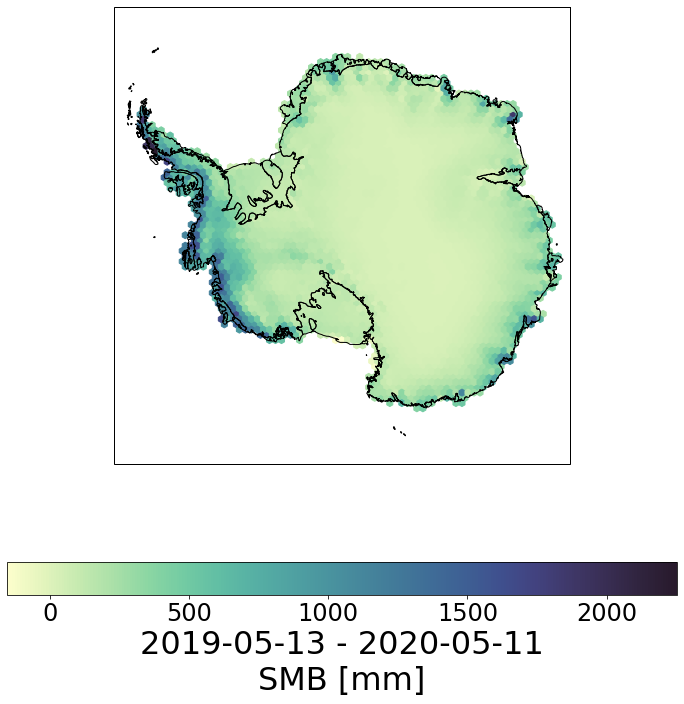

In [9]:
label = str(t0)[0:10] + " - " + str(tf)[0:10] + "\nSMB [mm]"
smb_hb = plot_hexbin(x_M2, y_M2, smb, nbins, extent, Deep_20.mpl_colormap, label)

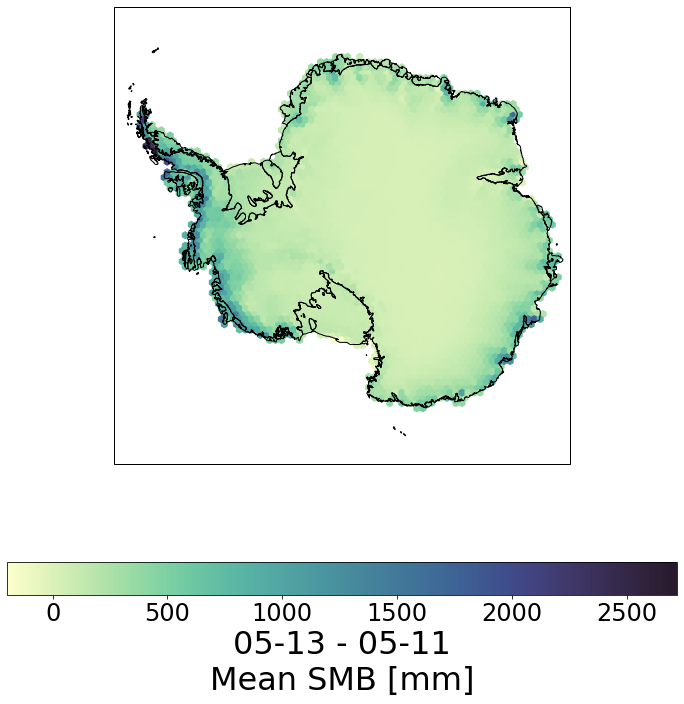

In [10]:
label = str(t0)[5:10] + " - " + str(tf)[5:10] + "\nMean SMB [mm]"
mean_smb_hb = plot_hexbin(x_M2, y_M2, mean_smb, nbins, extent, Deep_20.mpl_colormap, label)

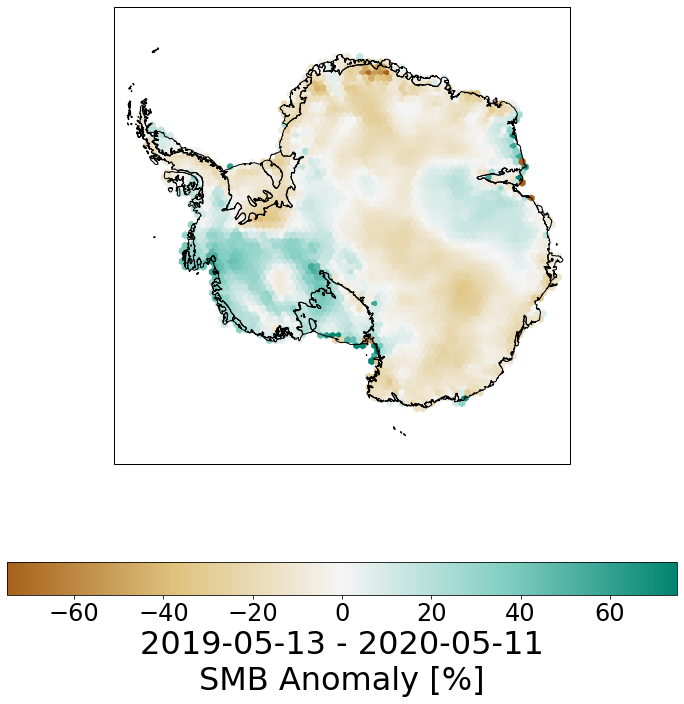

In [11]:
label = str(t0)[0:10] + " - " + str(tf)[0:10] + "\nSMB Anomaly [%]"
anomaly_hb = plot_hexbin(x_M2, y_M2, anomaly, nbins, extent, BrBG_5.mpl_colormap, label, -75.0, 75.0)

# Make a scatter plot of SMB anomaly vs surface height change

In [12]:
# Define Y value of scatter plot
y = dh_hb.get_array()
x = np.zeros(len(y)); x[:] = np.nan

# Define number of points
n = len(y)

In [13]:
# Loop through each index of IC2, and find the corresponding indices of M2
for j in range(0, n):
    for k in range(0, anomaly_hb.get_offsets().shape[0]):
        if dh_hb.get_offsets()[j, 0] == anomaly_hb.get_offsets()[k, 0] and dh_hb.get_offsets()[j, 1] == anomaly_hb.get_offsets()[k, 1]:
            x[j] = anomaly_hb.get_array()[k]
            break

(-75, 75)

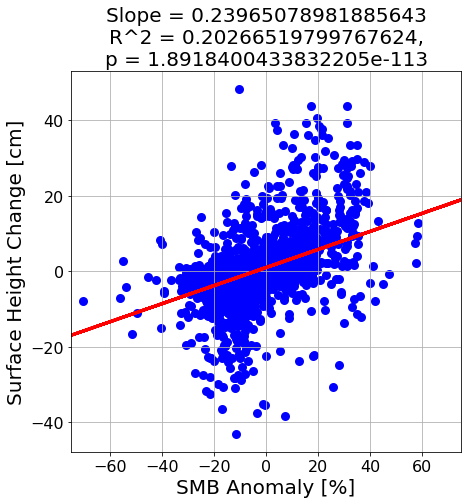

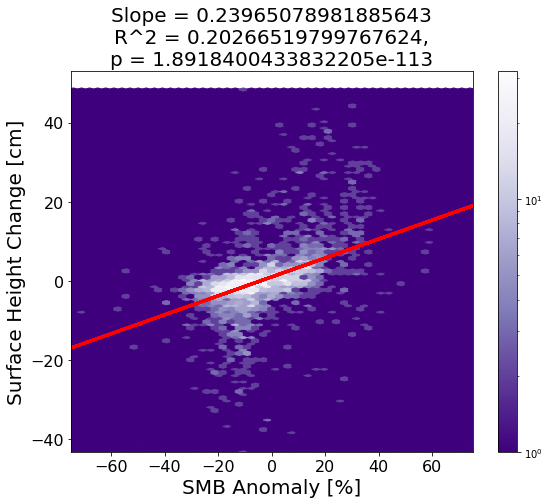

In [14]:
non_nan_inds = ~np.isnan(y)
x = x[non_nan_inds]
y = y[non_nan_inds]
non_nan_inds = ~np.isnan(x)
x = x[non_nan_inds]
y = y[non_nan_inds]
lin_reg = stats.linregress(x, y)

plt.figure(figsize=(7, 7))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
plt.grid()
plt.xlabel("SMB Anomaly [%]", fontsize=20)
plt.ylabel("Surface Height Change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue), \
         fontsize=20)
plt.xlim([-75, 75])

plt.figure(figsize=(9, 7))
plt.hexbin(x, y, bins='log', cmap=plt.cm.Purples_r)
plt.colorbar()
plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
# plt.grid()
plt.xlabel("SMB Anomaly [%]", fontsize=20)
plt.ylabel("Surface Height Change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue), \
         fontsize=20)
plt.xlim([-75, 75])

# How big are the hexagonal grid cells

In [15]:
a_ais = 14200904.81 # Units km^2
n_cells = len(anomaly_hb.get_array())
grid_cell_size = np.sqrt(a_ais / n_cells) # Units km
print(grid_cell_size)

70.05009760767294
